#Requirements#

In [ ]:
# First, install PyTorch with CUDA support
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu118

# Install required packages
!pip install transformers
!pip install opencv-python
!pip install scipy
!pip install setuptools==59.5.0
!pip install pillow
!pip install timm

# Install OneFormer specific dependencies
!pip install -q git+https://github.com/cocodataset/panopticapi.git
!pip install -q git+https://github.com/mcordts/cityscapesScripts.git
!pip install -q pytorchvideo

# Optional: for better visualization
!pip install matplotlib seaborn

# Verify CUDA is available
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Import and verify transformers installation
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation

# Test model loading
processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_large")
model = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_ade20k_swin_large")

print("Setup completed successfully!")

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 980, in exec_module
  File "<frozen site>", line 642, in <module>
  File "<frozen site>", line 629, in main
  File "<frozen site>", line 410, in addsitepackages
  File "<frozen site>", line 242, in addsitedir
  File "<frozen site>", line 201, in addpackage
  File "<string>", line 1, in <module>
  File "/usr/local/lib/python3.11/dist-packages/_numba_cuda_redirector.py", line 2, in <module>
    import importlib.abc
  File "/usr/lib/python3.11/importlib/abc.py", line 19, in <module>
    from .resources.abc import ResourceReader, Traversable, TraversableResources
  File "/usr/lib/python3.11/import

#1ST VERSION#

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation

def process_image(image_path, output_dir=None):
    """Process a single image and generate segmentation masks using OneFormer"""
    # Previous initialization code remains the same until segmentation is computed
    processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_large")
    model = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_ade20k_swin_large")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    image = Image.open(image_path).convert('RGB')
    print(f"Processing image: {image_path}")
    print(f"Image size: {image.size}")

    inputs = processor(images=image, task_inputs=["semantic"], return_tensors="pt")
    inputs = {k: v.to(device) if hasattr(v, "to") else v for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    segmentation_maps = processor.post_process_semantic_segmentation(
        outputs,
        target_sizes=[(image.size[1], image.size[0])]
    )[0]

    segmentation = segmentation_maps.cpu().numpy()

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        base_filename = os.path.splitext(os.path.basename(image_path))[0]

        # Get unique classes and print them
        unique_classes = np.unique(segmentation)
        id2label = model.config.id2label
        print("\nDetected classes:")
        for class_id in unique_classes:
            if class_id > 0:  # Skip background class
                print(f"- Class {class_id}: {id2label[int(class_id)]}")

        # Create more distinct colors using HSV color space
        num_classes = len(model.config.id2label)
        colors = []
        for i in range(num_classes):
            hue = i / num_classes
            colors.append(plt.cm.hsv(hue))
        colors = np.array(colors)

        # Create colored segmentation
        colored_segmentation = colors[segmentation]

        # Convert original image to numpy array and normalize
        original_image = np.array(image).astype(float) / 255

        # Create overlay
        overlay = 0.6 * original_image + 0.4 * colored_segmentation[:,:,:3]

        # Create figure for plotting
        plt.figure(figsize=(20, 20))
        plt.imshow(overlay)

        # Add labels to segmented regions
        from scipy import ndimage

        for class_id in unique_classes:
            if class_id > 0:  # Skip background
                # Create mask for this class
                mask = segmentation == class_id
                # Find center of mass for this segment
                if mask.any():
                    # Get center of each connected component
                    labeled_mask, num_features = ndimage.label(mask)
                    for label_idx in range(1, num_features + 1):
                        component_mask = labeled_mask == label_idx
                        cy, cx = ndimage.center_of_mass(component_mask)
                        # Add text with white background for better visibility
                        plt.text(cx, cy, id2label[int(class_id)],
                               color='black',
                               bbox=dict(facecolor='white', alpha=0.7),
                               ha='center',
                               va='center',
                               fontsize=12)

        plt.axis('off')

        # Save the annotated overlay
        overlay_path = os.path.join(output_dir, f"{base_filename}_overlay_labeled.png")
        plt.savefig(overlay_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        print(f"Saved labeled overlay to: {overlay_path}")

        # Save original foreground mask
        foreground_mask = (segmentation > 0).astype(np.uint8) * 255
        mask_path = os.path.join(output_dir, f"{base_filename}_foreground_mask.png")
        Image.fromarray(foreground_mask).save(mask_path)
        print(f"Saved mask to: {mask_path}")

    return segmentation

def main():
    # Define paths
    input_dir = "/content/objects/"
    output_dir = "/content/output_masks"

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Get list of images
    valid_extensions = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')
    image_files = [
        f for f in os.listdir(input_dir)
        if os.path.isfile(os.path.join(input_dir, f))
        and f.lower().endswith(valid_extensions)
    ]

    if not image_files:
        print(f"No image files found in {input_dir}")
        return

    print(f"Found {len(image_files)} images to process")

    # Process each image
    for idx, image_file in enumerate(image_files, 1):
        print(f"\nProcessing image {idx}/{len(image_files)}")
        image_path = os.path.join(input_dir, image_file)

        try:
            process_image(image_path=image_path, output_dir=output_dir)
            print(f"Successfully processed {image_file}")
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
            import traceback
            traceback.print_exc()

if __name__ == "__main__":
    main()

Found 2 images to process

Processing image 1/2
Processing image: /content/objects/903254896.png
Image size: (1500, 1000)

Detected classes:
- Class 3: floor
- Class 5: ceiling
- Class 7: bed
- Class 8: window 
- Class 10: cabinet
- Class 14: door
- Class 17: plant
- Class 22: painting, picture
- Class 23: sofa
- Class 36: lamp
- Class 38: rail
- Class 63: blind, screen
- Class 82: light
- Class 125: pot
Saved labeled overlay to: /content/output_masks/903254896_overlay_labeled.png
Saved mask to: /content/output_masks/903254896_foreground_mask.png
Successfully processed 903254896.png

Processing image 2/2
Processing image: /content/objects/595043039.png
Image size: (1500, 1000)

Detected classes:
- Class 3: floor
- Class 5: ceiling
- Class 7: bed
- Class 8: window 
- Class 15: table
- Class 19: chair
- Class 36: lamp
- Class 39: cushion
- Class 57: pillow
- Class 64: coffee table
- Class 148: clock
Saved labeled overlay to: /content/output_masks/595043039_overlay_labeled.png
Saved mask 

#2ND VERSION#

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation

def process_image(image_path, output_dir=None):
  """Process a single image and generate segmentation masks using OneFormer"""
  processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_large")
  model = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_ade20k_swin_large")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  model.eval()

  image = Image.open(image_path).convert('RGB')
  print(f"Processing image: {image_path}")
  print(f"Image size: {image.size}")

  inputs = processor(images=image, task_inputs=["semantic"], return_tensors="pt")
  inputs = {k: v.to(device) if hasattr(v, "to") else v for k, v in inputs.items()}

  with torch.no_grad():
      outputs = model(**inputs)

  segmentation_maps = processor.post_process_semantic_segmentation(
      outputs,
      target_sizes=[(image.size[1], image.size[0])]
  )[0]

  segmentation = segmentation_maps.cpu().numpy()

  # Define background classes (architectural elements to exclude)
  background_classes = [0, 1, 3, 5, 4, 6, 8, 9, 14, 38]  # 0 is original background

  if output_dir:
      os.makedirs(output_dir, exist_ok=True)
      base_filename = os.path.splitext(os.path.basename(image_path))[0]

      # First, let's print all detected classes for debugging
      all_classes = np.unique(segmentation)
      id2label = model.config.id2label

      print("\nAll detected classes:")
      for class_id in all_classes:
          print(f"- Class {class_id}: {id2label[int(class_id)]}")

      # Create foreground mask - FIXED VERSION
      foreground_mask = np.ones_like(segmentation, dtype=np.uint8) * 255
      for bg_class in background_classes:  # <-- Changed to iterate over background_classes
          foreground_mask[segmentation == bg_class] = 0

      # Create masked segmentation
      masked_segmentation = segmentation.copy()
      masked_segmentation[foreground_mask == 0] = 0

      # Get unique classes in masked result
      unique_classes = np.unique(masked_segmentation)

      print("\nClasses in final mask (after excluding background elements):")
      for class_id in unique_classes:
          if class_id > 0:  # Skip 0 class
              print(f"- Class {class_id}: {id2label[int(class_id)]}")

      # Rest of visualization code remains the same
      num_classes = len(model.config.id2label)
      colors = []
      for i in range(num_classes):
          hue = i / num_classes
          colors.append(plt.cm.hsv(hue))
      colors = np.array(colors)

      colored_segmentation = colors[masked_segmentation]
      original_image = np.array(image).astype(float) / 255
      overlay = 0.6 * original_image + 0.4 * colored_segmentation[:,:,:3]

      plt.figure(figsize=(20, 20))
      plt.imshow(overlay)

      from scipy import ndimage

      for class_id in unique_classes:
          if class_id > 0:  # Skip 0 class
              mask = masked_segmentation == class_id
              if mask.any():
                  labeled_mask, num_features = ndimage.label(mask)
                  for label_idx in range(1, num_features + 1):
                      component_mask = labeled_mask == label_idx
                      cy, cx = ndimage.center_of_mass(component_mask)
                      plt.text(cx, cy, id2label[int(class_id)],
                              color='black',
                              bbox=dict(facecolor='white', alpha=0.7),
                              ha='center',
                              va='center',
                              fontsize=12)

      plt.axis('off')

      overlay_path = os.path.join(output_dir, f"{base_filename}_overlay_labeled.png")
      plt.savefig(overlay_path, bbox_inches='tight', pad_inches=0)
      plt.close()
      print(f"Saved labeled overlay to: {overlay_path}")

      mask_path = os.path.join(output_dir, f"{base_filename}_foreground_mask.png")
      Image.fromarray(foreground_mask).save(mask_path)
      print(f"Saved mask to: {mask_path}")

  return segmentation

def main():
    # Define paths
    input_dir = "/content/objects/"
    output_dir = "/content/output_masks"

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Get list of images
    valid_extensions = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')
    image_files = [
        f for f in os.listdir(input_dir)
        if os.path.isfile(os.path.join(input_dir, f))
        and f.lower().endswith(valid_extensions)
    ]

    if not image_files:
        print(f"No image files found in {input_dir}")
        return

    print(f"Found {len(image_files)} images to process")

    # Process each image
    for idx, image_file in enumerate(image_files, 1):
        print(f"\nProcessing image {idx}/{len(image_files)}")
        image_path = os.path.join(input_dir, image_file)

        try:
            process_image(image_path=image_path, output_dir=output_dir)
            print(f"Successfully processed {image_file}")
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
            import traceback
            traceback.print_exc()

if __name__ == "__main__":
    main()

Found 2 images to process

Processing image 1/2
Processing image: /content/objects/903254896.png
Image size: (1500, 1000)

All detected classes:
- Class 0: wall
- Class 3: floor
- Class 5: ceiling
- Class 7: bed
- Class 8: window 
- Class 10: cabinet
- Class 14: door
- Class 17: plant
- Class 22: painting, picture
- Class 23: sofa
- Class 36: lamp
- Class 38: rail
- Class 63: blind, screen
- Class 82: light
- Class 125: pot

Classes in final mask (after excluding background elements):
- Class 7: bed
- Class 10: cabinet
- Class 17: plant
- Class 22: painting, picture
- Class 23: sofa
- Class 36: lamp
- Class 63: blind, screen
- Class 82: light
- Class 125: pot
Saved labeled overlay to: /content/output_masks/903254896_overlay_labeled.png
Saved mask to: /content/output_masks/903254896_foreground_mask.png
Successfully processed 903254896.png

Processing image 2/2
Processing image: /content/objects/595043039.png
Image size: (1500, 1000)

All detected classes:
- Class 0: wall
- Class 3: floo

# ControlNet #

In [ ]:
!pip install diffusers transformers accelerate --quiet

In [ ]:
import torch
import numpy as np
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, DDIMScheduler
from diffusers import StableDiffusionPipeline
from diffusers.utils import load_image

# Load ControlNet (Inpaint Version)
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_inpaint",
    torch_dtype=torch.float16
)

# Load Stable Diffusion v1-5
pipe = StableDiffusionPipeline.from_pretrained("sd-legacy/stable-diffusion-v1-5", torch_dtype=torch.float16)

# Set Scheduler
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

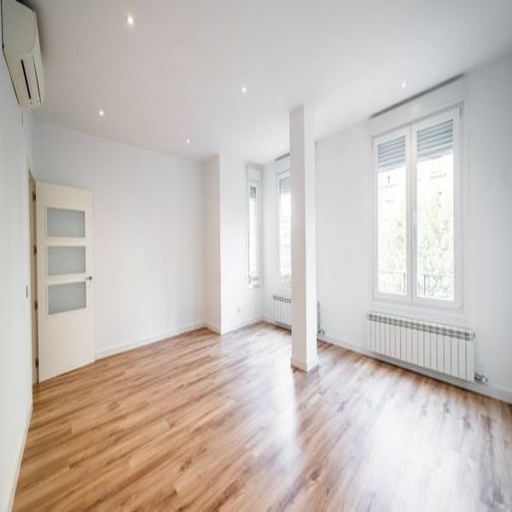

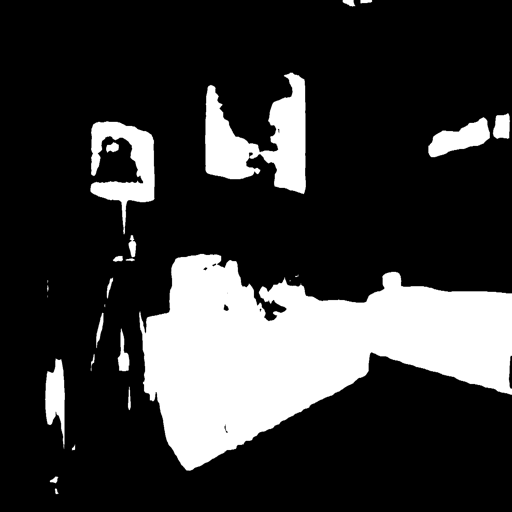

torch.Size([1, 3, 512, 512])


In [ ]:
# Load initial image
init_image = load_image("/content/1051079023.jpg")  # Ensure this file exists in Colab
init_image = init_image.resize((512, 512))

# Load mask image
mask_image = load_image("/content/903254896_foreground_mask.png")  # Ensure this file exists in Colab
mask_image = mask_image.resize((512, 512))

# Convert to proper inpainting format
def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[:2] == image_mask.shape[:2], "Image and mask size must match"
    image[image_mask > 0.5] = -1.0  # Mark masked pixels
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    return torch.from_numpy(image)

display(init_image)
display(mask_image)


init_image = make_inpaint_condition(init_image, mask_image)
print(init_image.shape)  # Should be (1, 3, 512, 512)



  0%|          | 0/10 [00:00<?, ?it/s]

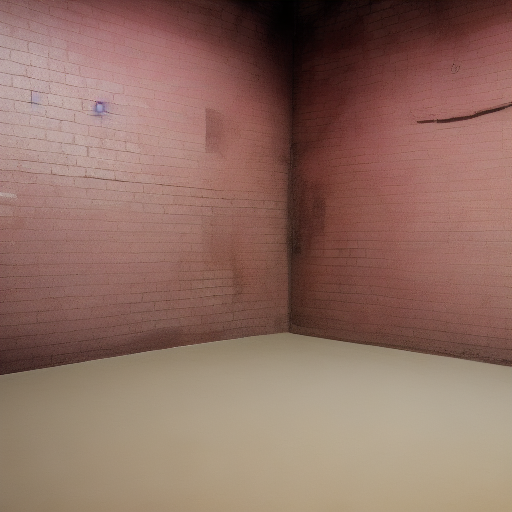

In [ ]:
# Set random seed for reproducibility
generator = torch.Generator(device="cpu").manual_seed(1)

# Generate image
image = pipe(
    "an empty room with no furniture",
    num_inference_steps=10,
    generator=generator,
    eta=1.0,
    image=init_image,
    mask_image=mask_image,
    control_image=control_image,
).images[0]

# Show result
display(image)


#OTHER STUFF

In [ ]:
# First, install PyTorch with CUDA support
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu118

# Install required packages
!pip install transformers
!pip install opencv-python
!pip install timm

# Install NATTEN for DiNAT backbone
!pip install natten

# Optional: restart runtime here to ensure NATTEN is properly loaded
print("Setup complete! Please restart your runtime before running the main code.")

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for natten: filename=natten-0.17.4-cp311-cp311-linux_x86_64.whl size=4358775 sha256=e1eb6baef745dbfda364fa29bfad6fab702c88e518e35752d0b9abad9be4cb81
  Stored in directory: /root/.cache/pip/wheels/83/19/8e/adb05321edf21bd8c0930a65c03941df764940b6dce31ea252
Successfully built natten
Setup complete! Please restart your runtime before running the main code.


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation

def get_background_classes():
    """
    Define background/structural classes in ADE20K to exclude.
    These will be used to identify everything else as foreground objects.
    """
    return {
        'wall': 1,
        'floor': 4,
        'ceiling': 6,
        'windowpane': 9,
        'door': 15,
        'stairs': 24,
        'column': 91,
        'window': 9,
        'radiator': 67,
        'vent': 104,
    }

def process_image(image_path, output_dir=None, verbose=True):
    """Process a single image using all three segmentation modes"""
    # Initialize model and processor
    model_name = "shi-labs/oneformer_ade20k_dinat_large"
    processor = OneFormerProcessor.from_pretrained(model_name)
    model = OneFormerForUniversalSegmentation.from_pretrained(model_name)

    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Load image
    image = Image.open(image_path).convert('RGB')
    print(f"\nProcessing image: {image_path}")
    print(f"Image size: {image.size}")

    # Get background classes
    background_classes = get_background_classes()
    background_indices = list(background_classes.values())

    # Process all three segmentation modes
    segmentation_results = {}

    for task in ["semantic", "instance", "panoptic"]:
        print(f"\nProcessing {task} segmentation...")

        # Prepare inputs
        inputs = processor(images=image, task_inputs=[task], return_tensors="pt")
        inputs = {k: v.to(device) if hasattr(v, "to") else v for k, v in inputs.items()}

        # Run inference
        with torch.no_grad():
            outputs = model(**inputs)

        # Post-process based on task
        if task == "semantic":
            result = processor.post_process_semantic_segmentation(
                outputs, target_sizes=[image.size[::-1]])[0]
            segmentation = result.cpu().numpy()

        elif task == "instance":
            result = processor.post_process_instance_segmentation(
                outputs, target_sizes=[image.size[::-1]])[0]
            segmentation = result["segmentation"].cpu().numpy()

        else:  # panoptic
            result = processor.post_process_panoptic_segmentation(
                outputs, target_sizes=[image.size[::-1]])[0]
            segmentation = result["segmentation"].cpu().numpy()

        segmentation_results[task] = segmentation

        # Create foreground mask
        foreground_mask = np.ones_like(segmentation, dtype=np.uint8)
        for bg_class in background_indices:
            foreground_mask[segmentation == (bg_class - 1)] = 0

        if verbose:
            # Print detected objects and their percentages
            print(f"\nDetected Objects ({task}):")
            unique_classes = np.unique(segmentation)
            detected_objects = []

            for class_idx in unique_classes:
                pixel_count = np.sum(segmentation == class_idx)
                percentage = (pixel_count / segmentation.size) * 100

                if percentage > 0.5:  # Only show objects that cover more than 0.5% of the image
                    actual_idx = class_idx + 1
                    is_background = actual_idx in background_indices
                    type_label = "BACKGROUND" if is_background else "FOREGROUND"
                    detected_objects.append((f"Class {actual_idx}", percentage, actual_idx, type_label))

            # Sort by percentage and print
            detected_objects.sort(key=lambda x: x[1], reverse=True)
            for obj_name, percentage, class_idx, type_label in detected_objects:
                print(f"{'✗' if type_label == 'BACKGROUND' else '✓'} {obj_name} ({type_label}): {percentage:.1f}% of image")

        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            base_filename = os.path.splitext(os.path.basename(image_path))[0]

            # Save foreground mask
            mask_path = os.path.join(output_dir, f"{base_filename}_{task}_mask.png")
            Image.fromarray(foreground_mask * 255).save(mask_path)
            print(f"Saved {task} mask to: {mask_path}")

            # Save visualization
            if verbose:
                # Create colored visualization
                vis = np.zeros((segmentation.shape[0], segmentation.shape[1], 3), dtype=np.uint8)
                colors = np.random.randint(50, 255, (len(unique_classes), 3), dtype=np.uint8)

                # Assign different colors to different foreground objects
                for i, class_idx in enumerate(unique_classes):
                    if (class_idx + 1) not in background_indices:
                        mask = segmentation == class_idx
                        vis[mask] = colors[i]

                vis_path = os.path.join(output_dir, f"{base_filename}_{task}_vis.png")
                Image.fromarray(vis).save(vis_path)
                print(f"Saved {task} visualization to: {vis_path}")

    return segmentation_results

def main():
    # Define paths
    input_dir = "/content/objects/"
    output_dir = "/content/output_masks"

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Get list of images
    valid_extensions = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp')
    image_files = [
        f for f in os.listdir(input_dir)
        if os.path.isfile(os.path.join(input_dir, f))
        and f.lower().endswith(valid_extensions)
    ]

    if not image_files:
        print(f"No image files found in {input_dir}")
        return

    print(f"Found {len(image_files)} images to process")

    # Process each image
    for idx, image_file in enumerate(image_files, 1):
        print(f"\nProcessing image {idx}/{len(image_files)}")
        image_path = os.path.join(input_dir, image_file)

        try:
            segmentation_results = process_image(image_path=image_path, output_dir=output_dir, verbose=True)
            print(f"Successfully processed {image_file}")
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
            import traceback
            traceback.print_exc()

if __name__ == "__main__":
    main()

Found 2 images to process

Processing image 1/2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `OneFormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)



Processing image: /content/objects/903254896.png
Image size: (1500, 1000)

Processing semantic segmentation...


| 2025-02-16 18:36:18,140 | [[ natten.functional ]] [ WARNING ]: You're calling NATTEN op `natten.functional.natten2dqkrpb`, which is deprecated in favor of `natten.functional.na2d_qk`. Please consider switching, as this op will be removed soon.
| 2025-02-16 18:37:23,830 | [[ natten.functional ]] [ WARNING ]: You're calling NATTEN op `natten.functional.natten2dav`, which is deprecated in favor of `natten.functional.na2d_av`. Please consider switching, as this op will be removed soon.
| 2025-02-16 18:37:37,780 | [[ natten.functional ]] [ WARNING ]: You're calling NATTEN op `natten.functional.natten2dqkrpb`, which is deprecated in favor of `natten.functional.na2d_qk`. Please consider switching, as this op will be removed soon.
| 2025-02-16 18:39:18,877 | [[ natten.functional ]] [ WARNING ]: You're calling NATTEN op `natten.functional.natten2dav`, which is deprecated in favor of `natten.functional.na2d_av`. Please consider switching, as this op will be removed soon.
| 2025-02-16 18:39:37,


Detected Objects (semantic):
✗ Class 1 (BACKGROUND): 33.0% of image
✗ Class 4 (BACKGROUND): 17.1% of image
✗ Class 24 (BACKGROUND): 13.2% of image
✗ Class 15 (BACKGROUND): 9.1% of image
✗ Class 6 (BACKGROUND): 7.1% of image
✓ Class 23 (FOREGROUND): 5.4% of image
✓ Class 8 (FOREGROUND): 4.7% of image
✗ Class 9 (BACKGROUND): 4.3% of image
✓ Class 37 (FOREGROUND): 3.0% of image
✓ Class 64 (FOREGROUND): 2.5% of image
Saved semantic mask to: /content/output_masks/903254896_semantic_mask.png
Saved semantic visualization to: /content/output_masks/903254896_semantic_vis.png

Processing instance segmentation...


| 2025-02-16 18:51:50,535 | [[ natten.functional ]] [ WARNING ]: You're calling NATTEN op `natten.functional.natten2dqkrpb`, which is deprecated in favor of `natten.functional.na2d_qk`. Please consider switching, as this op will be removed soon.


KeyboardInterrupt: 